In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
import csv
from scipy import integrate
from car_park_functions import *
import math

In [2]:
bolTrainagain = False # will try to load data if false 

In [3]:
available_parkings = ['Vilanova', 'SantSadurni', 'SantBoi', 'QuatreCamins',
                      'Cerdanyola','Granollers','Martorell','Mollet',
                      'SantQuirze','PratDelLlobregat']
df_column_name=['Parking Vilanova Renfe','Parking Sant Sadurní Renfe','Parking Sant Boi de Llobregat',
              'Parking Quatre Camins','Cerdanyola Universitat Renfe','Parking Granollers Renfe',
                'Parking Martorell FGC','Parking Mollet Renfe','Parking Sant Quirze FGC',
               'Parking Prat del Ll.']
current_parking_ix=3
# problems on Weekend with 2 SantBoi, 4 Cerdanyola, 
# bad data: 6 Martorell, 8 SantQuirze DO NOT USE
#good 0 Vilanova, 1 SantSadurni, 4 QuatreCamins, 5 Granollers, 7 Mollet, 9 PratDelLlobregat 
current_parking = available_parkings[current_parking_ix]
current_column_name=df_column_name[current_parking_ix]


# loadind data:
    # Getting back the objects:
with open('data/'+current_parking+'_normalized.pkl','rb') as f:  # Python 3: open(..., 'rb')
    df_normalized, weekday_offset, friday_offset,  weekend_offset, max_value= pickle.load(f)
    f.close()
axis_ylim = max_value+20

df_training, df_testing = split_data(df_normalized, 3)



df_mean_areas = df_training.groupby(['Profile_3'], as_index=False).mean() 
df_mean_areas[['Profile_3', 'Area']]

friday_area = df_mean_areas.iloc[0]['Area']
weekday_area = df_mean_areas.iloc[1]['Area']
weekend_area = df_mean_areas.iloc[2]['Area']

friday_max = df_mean_areas.iloc[0]['MaxV']
weekday_max = df_mean_areas.iloc[1]['MaxV']
weekend_max = df_mean_areas.iloc[2]['MaxV']

print('Weekday area: ' , weekday_area)
print('Friday area: ' , friday_area)
print('Weekend area: ' , weekend_area)

print('Weekday maximum: ' , weekday_max)
print('Friday maximum: ' , friday_max)
print('Weekend maximum: ' , weekend_max)

Weekday area:  3516.6577380952117
Friday area:  3082.0952380952285
Weekend area:  523.6141262509632
Weekday maximum:  144.64285714285714
Friday maximum:  140.71428571428572
Weekend maximum:  26.775981524249424


## MATHEMATICAL MODEL - CDF Subtraction

In [4]:
# ********************************************** WEEKDAY *************************************************************
#from scipy.special import tna, factorial
from scipy.optimize import minimize
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
time = np.linspace(0,23.5,48)
time_tn=time/24


#training_weekdays_norm  = get_days_of_protos_normalized("Weekday", df_training)
#training_fridays_norm  = get_days_of_protos_normalized("Friday", df_training)
#training_weekends_norm  = get_days_of_protos_normalized("Weekend", df_training)
training_weekdays_norm  = get_days_of_protos_areanormalized("Weekday", df_training)
training_fridays_norm  = get_days_of_protos_areanormalized("Friday", df_training)
training_weekends_norm  = get_days_of_protos_areanormalized("Weekend", df_training)

training_weekends_norm = training_weekends_norm[:-1]

training_weekdays_isfull  = get_parkingfull_of_protos("Weekday", df_training)
training_weekdays_date  =  get_dates_of_protos("Weekday", df_training)
training_fridays_isfull  = get_parkingfull_of_protos("Friday", df_training)
training_fridays_date  =  get_dates_of_protos("Friday", df_training)
training_weekends_date  =  get_dates_of_protos("Weekday", df_training)

# training_weekends_norm = t
wd_length = len(training_weekdays_norm)
f_length = len(training_fridays_norm)
we_length = len(training_weekends_norm)

parameters_tn = np.array([.2 ,.05,.7,.1])
#optimal_params_weekdaytn = minimize(model_tn_areaN, parameters_tn, args=(training_weekdays_norm), method='Nelder-Mead',
#                                    tol=1e-6, options={'disp': True})

if bolTrainagain:

    errors_wd = np.ones(np.shape(training_weekdays_norm))
    optimal_params_weekdaytn = minimize(model_tn_areaN_args,
                                    parameters_tn, 
                                    args=(training_weekdays_norm, errors_wd),
                                    method='Nelder-Mead',
                                    tol=1e-6, options={'disp': True, 'maxfev': 10000})
    
else:
    #load data
    with open('data/'+current_parking+'_modelFit.pkl','rb') as f:  # Python 3: open(..., 'rb')
        [optimal_params_weekdaytn, errors_wd, optimal_params_fridaytn, 
                     errors_fr, optimal_params_weekendtn, errors_we]= pickle.load(f)
        f.close()

In [5]:
var_weekdaytn = np.mean(errors_wd)
stdv_weekdaytn=math.sqrt(var_weekdaytn)
print('global stdv %.5f\n' % stdv_weekdaytn)
stdv_weekday30mins = np.sqrt(np.mean(errors_wd,0))
print('stdv per time-step')
#for i in stdv_weekday30mins:
#    print('\t' + str(i))

global stdv 0.00231

stdv per time-step


In [6]:
optimal_params_weekdaytn

 final_simplex: (array([[0.30350063, 0.02959791, 0.8057803 , 0.07834087],
       [0.30350048, 0.02959731, 0.80578042, 0.07834103],
       [0.30350054, 0.02959748, 0.80578077, 0.07834033],
       [0.30350084, 0.02959737, 0.80578073, 0.07834165],
       [0.30350085, 0.02959741, 0.80578021, 0.07834097]]), array([0.00718209, 0.00718209, 0.00718209, 0.00718209, 0.00718209]))
           fun: 0.007182093096028476
       message: 'Optimization terminated successfully.'
          nfev: 323
           nit: 190
        status: 0
       success: True
             x: array([0.30350063, 0.02959791, 0.8057803 , 0.07834087])

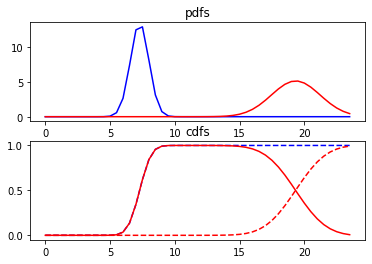

In [7]:
plot_model_tn(optimal_params_weekdaytn.x[0],optimal_params_weekdaytn.x[1],optimal_params_weekdaytn.x[2],optimal_params_weekdaytn.x[3])

In [8]:
weekday_math_params = optimal_params_weekdaytn.x
weekday_math_params

array([0.30350063, 0.02959791, 0.8057803 , 0.07834087])

In [9]:
time2 = np.linspace(0,23.5,48)
time_tn=time2/24
tn1_wd=tn(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
tn2_wd=tn(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])
#tn1_wd = gam(time2, optimal_params_weekday.x[0], optimal_params_weekday.x[1])
#tn2_wd = gam(time2, optimal_params_weekday.x[2], optimal_params_weekday.x[3])

#cdf1_wd_ap = generate_cdf(tn1_wd)
#cdf2_wd_ap = generate_cdf(tn2_wd)
cdf1_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
cdf2_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])
#cdf1_wd = generate_cdf(tn1_wd)
#cdf2_wd = generate_cdf(tn2_wd)

resta_wd = np.array(cdf1_wd) - np.array(cdf2_wd)
prototype_math_weekday = resta_wd/sum(resta_wd)

#resta_wd_ap= np.array(cdf1_wd_ap) - np.array(cdf2_wd_ap)
#prototype_math_weekday_ap = resta_wd_ap/sum(resta_wd_ap)

#fig = plt.figure(figsize=(18,10))
#fig.suptitle("PDF and CDF for arrival and deartures - WEEKDAYS ("+current_parking+")", fontsize=20)
#plt.plot(time2, tn1_wd/sum(tn1_wd), label="Probability that a slot gets occupied")
#plt.plot(time2, tn2_wd/sum(tn2_wd),  label="Probability that a slot gets free")
#plt.plot(time2, cdf1_wd, label="Cummulative probability arrival")
#plt.plot(time2, cdf2_wd, label="Cummulative probability departure")

#plt.grid(linestyle='dotted')
#plt.xlabel("Time [h]", fontsize=18)
#plt.ylabel("PDF & CDF", fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks(fontsize=18)
#plt.legend(fontsize=16, loc="upper left");


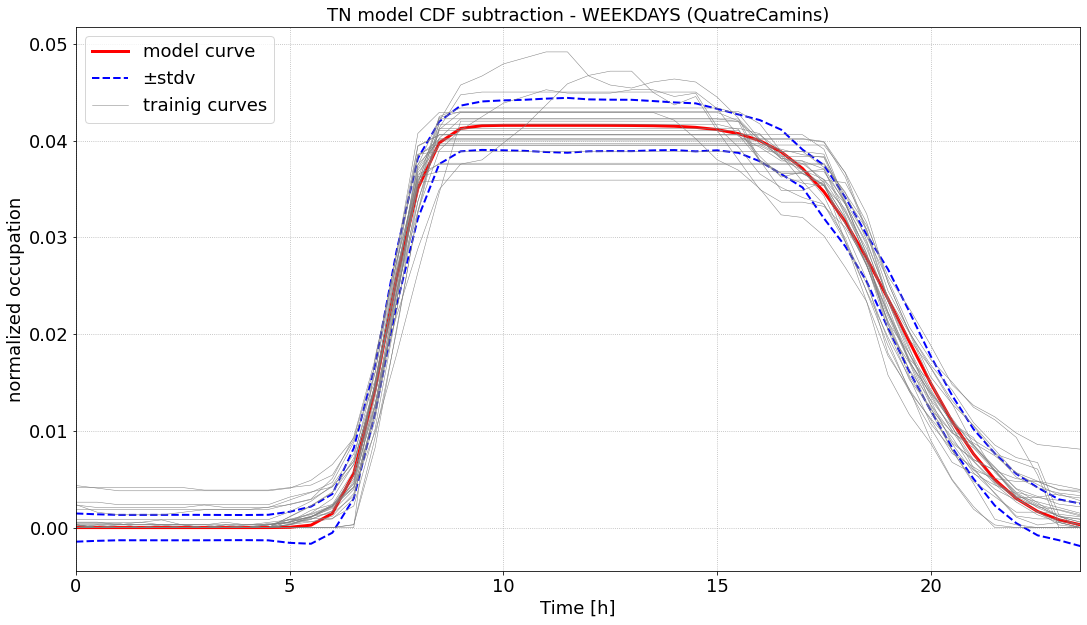

In [10]:
fsize=18
fig = plt.figure(figsize=(18,10))
plt.title("TN model CDF subtraction - WEEKDAYS ("+current_parking+")", fontsize=fsize)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=fsize)
plt.ylabel("normalized occupation", fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.plot(time2, prototype_math_weekday-stdv_weekday30mins, linewidth=2, linestyle='--', color='blue')
plt.plot(time2, prototype_math_weekday, linewidth=3, color='red', label="model curve")
plt.plot(time2, prototype_math_weekday+stdv_weekday30mins, linewidth=2, linestyle='--', color='blue', label="±stdv")
#plt.plot(time2, prototype_math_weekday_ap, linewidth=3, color='red', label="approx")
for i in range(0,len(training_weekdays_norm)):
    if i==0:
        plt.plot(time, training_weekdays_norm[i], linewidth=0.5, color='gray', label="trainig curves")
    else:
        plt.plot(time, training_weekdays_norm[i], linewidth=0.5, color='gray')

plt.xlim([0,23.5])
plt.legend(fontsize=fsize, loc="upper left");
fig.savefig('Training_'+current_parking+'.pdf',bbox_inches='tight');
fig.savefig('Training_'+current_parking+'.png',bbox_inches='tight');

### FRIDAYS

In [11]:
parameters_tn = np.array([.2 ,.05,.7,.1])
#optimal_params_fridaytn = minimize(model_tn_areaN, parameters_tn, args=(training_fridays_norm), method='Nelder-Mead',
#                                    tol=1e-6, options={'disp': True})

if bolTrainagain:
    errors_fr = np.ones(np.shape(training_fridays_norm))
    optimal_params_fridaytn = minimize(model_tn_areaN_args,
                                    parameters_tn, 
                                    args=(training_fridays_norm, errors_fr),
                                    method='Nelder-Mead',
                                    tol=1e-6, options={'disp': True})


In [12]:
var_fridaytn = np.mean(errors_fr)
stdv_fridaytn=math.sqrt(var_fridaytn)
print('global stdv %.5f\n' % stdv_fridaytn)
stdv_friday30mins = np.sqrt(np.mean(errors_fr,0))
print('stdv per time-step')
#for i in stdv_friday30mins:
#    print('\t' + str(i))

global stdv 0.00252

stdv per time-step


In [13]:
optimal_params_fridaytn

 final_simplex: (array([[0.30795902, 0.03340294, 0.76307383, 0.12298193],
       [0.307959  , 0.03340245, 0.76307403, 0.12298155],
       [0.30795926, 0.03340265, 0.76307425, 0.12298107],
       [0.30795898, 0.03340276, 0.76307348, 0.12298102],
       [0.30795895, 0.03340294, 0.76307441, 0.12298107]]), array([0.00213942, 0.00213942, 0.00213942, 0.00213942, 0.00213942]))
           fun: 0.002139422848213427
       message: 'Optimization terminated successfully.'
          nfev: 243
           nit: 135
        status: 0
       success: True
             x: array([0.30795902, 0.03340294, 0.76307383, 0.12298193])

In [14]:
#optimal_params_friday.x
#friday_math_params = optimal_params_friday.x
friday_math_params = optimal_params_fridaytn.x

In [15]:

#tn1_fri = gam(time, optimal_params_friday.x[0], optimal_params_friday.x[1])
#tn2_fri = gam(time, optimal_params_friday.x[2], optimal_params_friday.x[3])
tn1_fri=tn(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
tn2_fri=tn(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

#cdf1_fri = generate_cdf(tn1_fri)
#cdf2_fri = generate_cdf(tn2_fri)
#cdf1_fri = generate_cdf(tn1_fri)
#cdf2_fri = generate_cdf(tn2_fri)
cdf1_fri=tn_cdf(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
cdf2_fri=tn_cdf(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

resta = np.array(cdf1_fri) - np.array(cdf2_fri)
prototype_math_friday = resta/sum(resta)
#fig = plt.figure(figsize=(18,10))
#fig.suptitle("PDF and CDF for occupying and freeing a slot - FRIDAYS ("+current_parking+")", fontsize=20)
#plt.plot(time, cdf1_fri, label="CDF Slot occupied")
#plt.plot(time, cdf2_fri, label="CDF Slot free")
#plt.plot(time, tn1_fri/sum(tn1_fri), label="Probability that a slot gets occupied")
#plt.plot(time, tn2_fri/sum(tn2_fri),  label="Probability that a slot gets free")
#plt.grid(linestyle='dotted')
#plt.xlabel("Time [h]", fontsize=18)
#plt.ylabel("PDF & CDF", fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks(fontsize=18)
#plt.legend(fontsize=16, loc="upper left")

#plt.legend(fontsize=16)

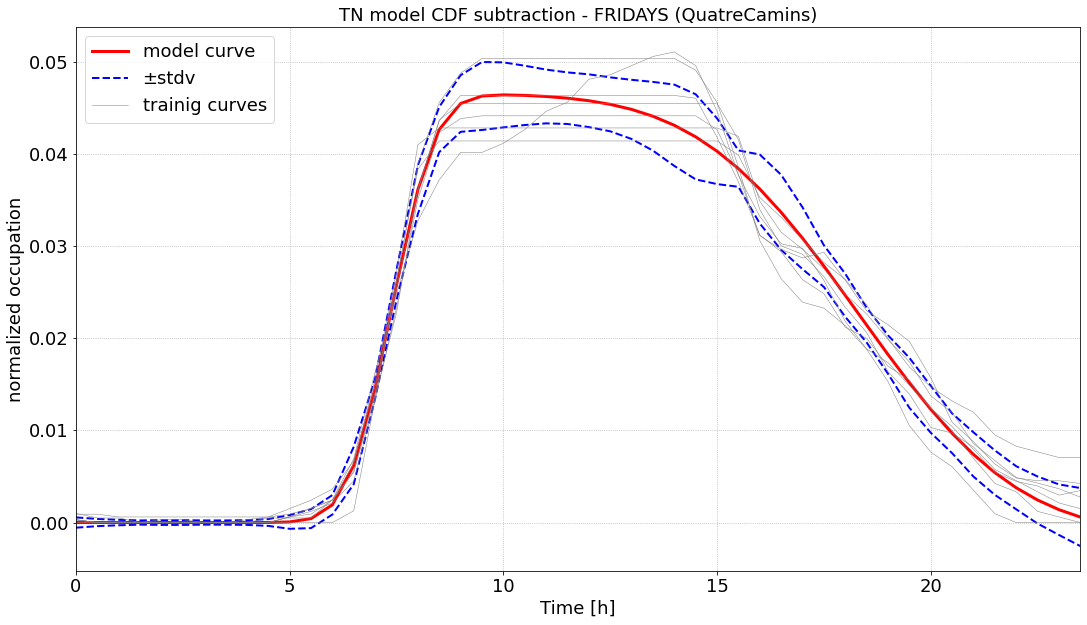

In [16]:
fsize=18
fig = plt.figure(figsize=(18,10))
plt.title("TN model CDF subtraction - FRIDAYS ("+current_parking+")", fontsize=fsize)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=fsize)
plt.ylabel("normalized occupation", fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.plot(time2, prototype_math_friday-stdv_friday30mins, linewidth=2, linestyle='--', color='blue')
plt.plot(time2, prototype_math_friday, linewidth=3, color='red', label="model curve")
plt.plot(time2, prototype_math_friday+stdv_friday30mins, linewidth=2, linestyle='--', color='blue', label="±stdv")

#plt.plot(time2, prototype_math_weekday_ap, linewidth=3, color='red', label="approx")
for i in range(0,len(training_fridays_norm)):
    if i==0:
        plt.plot(time, training_fridays_norm[i], linewidth=0.5, color='gray', label="trainig curves")
    else:
        plt.plot(time, training_fridays_norm[i], linewidth=0.5, color='gray')

plt.xlim([0,23.5])
plt.legend(fontsize=fsize, loc="upper left");
fig.savefig('Training_'+current_parking+'_FRIDAY.pdf',bbox_inches='tight');

### WEEKENDS

In [17]:
parameters_tn = np.array([.2 ,.05,.7,.1])
if bolTrainagain:
    errors_we = np.ones(np.shape(training_weekends_norm))    
    if ((current_parking == "SantBoi") or (current_parking == "Cerdanyola")): 
        #optimal_params_weekendtn = minimize(model_tn_areaN_args, parameters_tn, args=(training_weekends_norm), method='SLSQP',
        #                                   bounds=((0, None), (0, None),(0, None),(0, None)),
        #                                    tol=1e-6, options={'disp': True, 'maxfev': 100000})
        optimal_params_weekendtn = minimize(model_tn_areaN_args,
                                        parameters_tn, 
                                        args=(training_weekends_norm, errors_we),
                                        method='SLSQP',
                                        bounds=((0, None), (0, None),(0, None),(0, None)),
                                        tol=1e-6, options={'disp': True, 'maxfev': 100000})
    else:
        #optimal_params_weekendtn = minimize(model_tn_areaN_args, parameters_tn, args=(training_weekends_norm), method='Nelder-Mead',
        #                                    tol=1e-6, options={'disp': True, 'maxfev': 100000})     

        optimal_params_weekendtn = minimize(model_tn_areaN_args,
                                        parameters_tn, 
                                        args=(training_weekends_norm, errors_we),
                                        method='Nelder-Mead',
                                        tol=1e-6, options={'disp': True, 'maxfev': 100000})
        

## save the model fits

In [18]:
if bolTrainagain:
    #save modelparams and error
    with open('data/'+current_parking+'_modelFit.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump([optimal_params_weekdaytn, errors_wd, optimal_params_fridaytn, 
                     errors_fr, optimal_params_weekendtn, errors_we], f)
        f.close()
    
    # Getting back the objects:
    with open('data/'+current_parking+'_modelFit.pkl','rb') as f:  # Python 3: open(..., 'rb')
        [optimal_params_weekdaytn, errors_wd, optimal_params_fridaytn, 
                     errors_fr, optimal_params_weekendtn, errors_we]= pickle.load(f)
        f.close()

In [19]:
var_weekendtn = np.mean(errors_we)
stdv_weekendtn=math.sqrt(var_weekendtn)
print('global stdv %.5f\n' % stdv_weekendtn)
stdv_weekend30mins = np.sqrt(np.mean(errors_we,0))
#print('stdv per time-step')
#for i in stdv_weekend30mins:
#    print('\t' + str(i))

global stdv 0.00844



In [20]:
weekend_math_params = optimal_params_weekendtn.x
optimal_params_weekendtn.x

array([0.39530175, 0.08861594, 0.95355598, 0.10502728])

In [21]:
#tn1_we = gam(time, optimal_params_weekend.x[0], optimal_params_weekend.x[1])
#tn2_we = gam(time, optimal_params_weekend.x[2], optimal_params_weekend.x[3])
tn1_we=tn(time_tn, optimal_params_weekendtn.x[0], optimal_params_weekendtn.x[1])
tn2_we=tn(time_tn, optimal_params_weekendtn.x[2], optimal_params_weekendtn.x[3])



#cdf1_we = generate_cdf(tn1_we)
#cdf2_we = generate_cdf(tn2_we)
cdf1_we = tn_cdf(time_tn, optimal_params_weekendtn.x[0], optimal_params_weekendtn.x[1])
cdf2_we = tn_cdf(time_tn, optimal_params_weekendtn.x[2], optimal_params_weekendtn.x[3])



resta_we = np.array(cdf1_we) - np.array(cdf2_we)
prototype_math_weekend = resta_we/sum(resta_we)
#fig = plt.figure(figsize=(18,10))
#fig.suptitle("PDF and CDF for occupying and freeing a slot - WEEKENDS ("+current_parking+")", fontsize=20)
#plt.plot(time, cdf1_we, label="CDF Slot occupied")
#plt.plot(time, cdf2_we, label="CDF Slot free")
#plt.plot(time, tn1_we/sum(tn1_we), label="Probability that a slot is occupied")
#plt.plot(time, tn2_we/sum(tn2_we),  label="Probability  a slot gets free")
#plt.grid(linestyle='dotted')
#plt.xlabel("Time [h]", fontsize=18)
#plt.ylabel("PDF & CDF", fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks(fontsize=18)
#plt.legend(fontsize=16, loc="upper left")



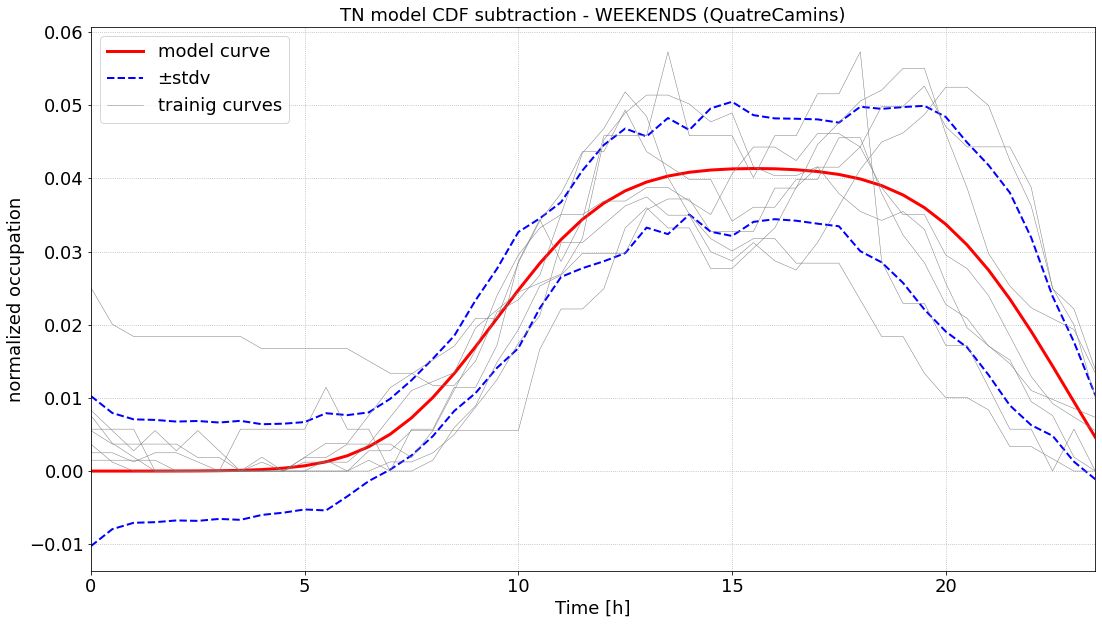

In [22]:
fsize=18
fig = plt.figure(figsize=(18,10))
plt.title("TN model CDF subtraction - WEEKENDS ("+current_parking+")", fontsize=fsize)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=fsize)
plt.ylabel("normalized occupation", fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.plot(time2, prototype_math_weekend-stdv_weekend30mins, linewidth=2, linestyle='--', color='blue')
plt.plot(time2, prototype_math_weekend, linewidth=3, color='red', label="model curve")
plt.plot(time2, prototype_math_weekend+stdv_weekend30mins, linewidth=2, linestyle='--', color='blue', label="±stdv")

for i in range(0,len(training_weekends_norm)):
    if i==0:
        plt.plot(time, training_weekends_norm[i], linewidth=0.5, color='gray', label="trainig curves")
    else:
        plt.plot(time, training_weekends_norm[i], linewidth=0.5, color='gray')

plt.xlim([0,23.5])
plt.legend(fontsize=fsize, loc="upper left");
fig.savefig('Training_'+current_parking+'WEEKEND.pdf',bbox_inches='tight');

In [23]:
printTimes(optimal_params_weekdaytn.x,current_parking,'WEEKDAYS')
printTimes(optimal_params_fridaytn.x,current_parking,'FRIDAYS')
printTimes(optimal_params_weekendtn.x,current_parking,'WEEKENDS')

--------- WEEKDAYS QuatreCamins -----------
Mean Arrival Time   = 07:17h
stdv Arrival        =  0:42h
Mean Departure Time = 19:20h
stdv Departure      =  1:52h
--------- FRIDAYS QuatreCamins -----------
Mean Arrival Time   = 07:23h
stdv Arrival        =  0:48h
Mean Departure Time = 18:18h
stdv Departure      =  2:57h
--------- WEEKENDS QuatreCamins -----------
Mean Arrival Time   = 09:29h
stdv Arrival        =  2:07h
Mean Departure Time = 22:53h
stdv Departure      =  2:31h


In [24]:
tn_weekday_n = prototype_math_weekday
tn_friday_n = prototype_math_friday
tn1_weekend_n = prototype_math_weekend

In [25]:
#**************************************WEEKDAY************************************
tn_weekday = tn_weekday_n*weekday_area + weekday_offset

#**************************************FRIDAY************************************
tn_friday = tn_friday_n*friday_area + friday_offset

#**************************************WEEKEND************************************
tn1_weekend = tn1_weekend_n*weekend_area + weekend_offset 

### Comparing normalized mathematical fitted prototype with testing data

### Denormalization / Rescaling

In [26]:

tn_weekday = tn_weekday_n*weekday_area + weekday_offset
tn_friday = tn_friday_n*friday_area + friday_offset
tn1_weekend = tn1_weekend_n*weekend_area + weekend_offset 



In [27]:
with open('data/'+current_parking+'_testing.pkl','rb') as f:  # Python 3: open(..., 'rb')
    [testing_mondays, testing_mondays_dates, testing_tuesdays, testing_tuesdays_dates, 
    testing_wednesdays, testing_wednesdays_dates, testing_thursdays, testing_thursdays_dates, 
    testing_fridays, testing_fridays_dates, testing_saturdays, testing_saturdays_dates,
    testing_sundays, testing_sundays_dates]= pickle.load(f)
    f.close()  
  

/Users/andreas/work/UPF/git/car-park/car_park_functions.py:440: RuntimeWarning: invalid value encountered in sqrt
  stdvE=np.sqrt(errors2/n_test_days-meanE*meanE)


______ MEAN ± STDV________
4.8280377103076555  ±  1.6406602808825335
4.460094931057472  ±  1.7002454401946145
5.19119970131748  ±  3.484887824674042
7.983031770860971  ±  4.818261974015827
14.800436211243829  ±  15.818026942143142
9.430566010693079  ±  1.4372362869198307
9.853805601082707  ±  5.059248970225774


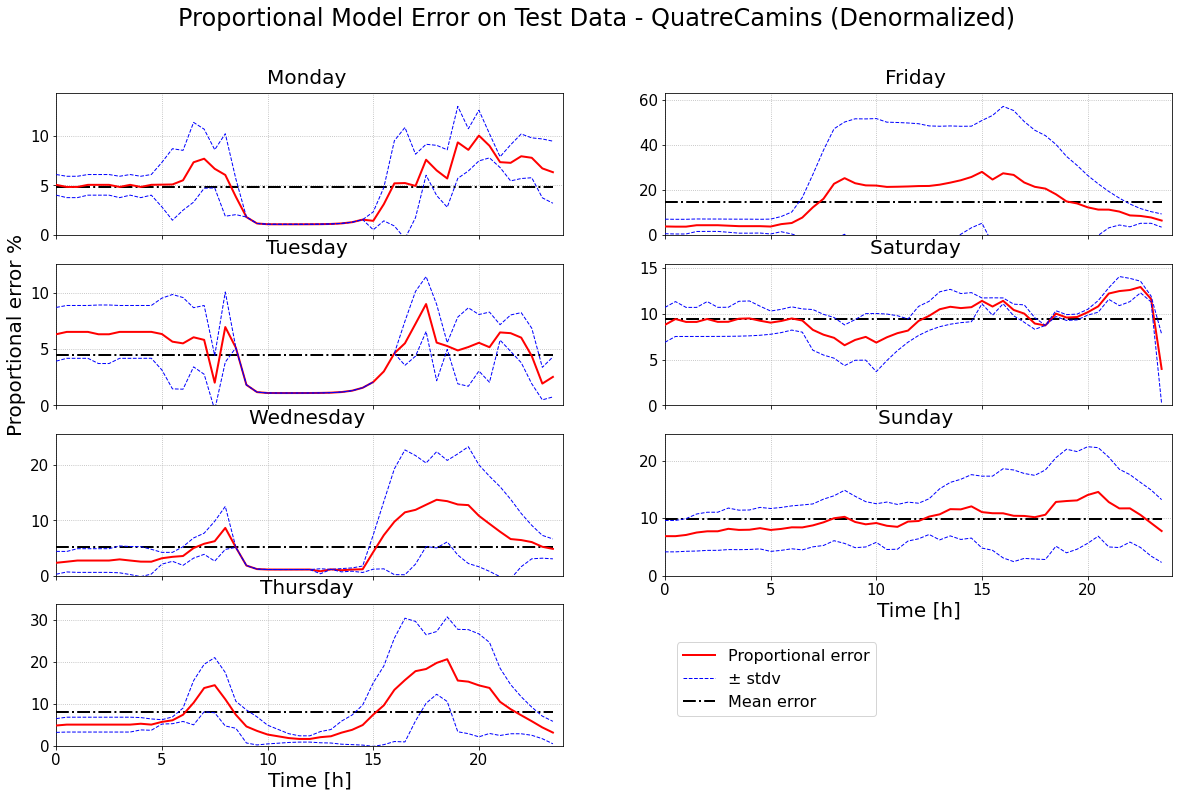

In [28]:
[error_monday_tn,stdv_error_monday_tn] = compute_testing_prop_errorMstdv(testing_mondays, tn_weekday, max_value)
[error_tuesday_tn,stdv_error_tuesday_tn] = compute_testing_prop_errorMstdv(testing_tuesdays, tn_weekday, max_value)
[error_wednesday_tn,stdv_error_wednesday_tn] = compute_testing_prop_errorMstdv(testing_wednesdays, tn_weekday, max_value)
[error_thursday_tn,stdv_error_thursday_tn] = compute_testing_prop_errorMstdv(testing_thursdays, tn_weekday, max_value)
[error_friday_tn,stdv_error_friday_tn] = compute_testing_prop_errorMstdv(testing_fridays, tn_friday, max_value)
[error_saturday_tn,stdv_error_saturday_tn] = compute_testing_prop_errorMstdv(testing_saturdays, tn1_weekend, max_value)
[error_sunday_tn,stdv_error_sunday_tn] = compute_testing_prop_errorMstdv(testing_sundays, tn1_weekend, max_value)


fig, ax = plt.subplots(4, 2)
fig.set_figwidth(20)
fig.set_figheight(12)
fig.suptitle('Proportional Model Error on Test Data - '+current_parking+' (Denormalized)', fontsize=24)
time = np.linspace(0,23.5,48)

mean_Monday =  [np.mean(error_monday_tn)]*len(time)
mstdv_Monday= np.mean(stdv_error_monday_tn[~np.isnan(stdv_error_monday_tn)])
subplotCDFsubtractionStdvErr(fig, ax, 0, 0, time, error_monday_tn, stdv_error_monday_tn, mean_Monday, 
                 'Monday ', 'Monday',False,False,False,False)

mean_Tuesday =  [np.mean(error_tuesday_tn)]*len(time)
mstdv_Tuesday= np.mean(stdv_error_tuesday_tn[~np.isnan(stdv_error_tuesday_tn)])
subplotCDFsubtractionStdvErr(fig, ax, 1, 0, time, error_tuesday_tn, stdv_error_tuesday_tn,  mean_Tuesday, 
                 'Tuesday ', 'Tuesday',False,True,False,False)

mean_Wednesday =  [np.mean(error_wednesday_tn)]*len(time)
mstdv_Wednesday= np.mean(stdv_error_wednesday_tn[~np.isnan(stdv_error_wednesday_tn)])
subplotCDFsubtractionStdvErr(fig, ax, 2, 0, time, error_wednesday_tn, stdv_error_wednesday_tn, mean_Wednesday, 
                 'Wednesday ', 'Wednesday',False,False,False,False)

mean_Thursday =  [np.mean(error_thursday_tn)]*len(time)
mstdv_Thursday= np.mean(stdv_error_thursday_tn[~np.isnan(stdv_error_thursday_tn)])
subplotCDFsubtractionStdvErr(fig, ax, 3, 0, time, error_thursday_tn, stdv_error_thursday_tn, mean_Thursday, 
                 'Thursday ', 'Thursday',True,False,True,False)

mean_Friday =  [np.mean(error_friday_tn)]*len(time)
mstdv_Friday= np.mean(stdv_error_friday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 0, 1, time, error_friday_tn, stdv_error_friday_tn, mean_Friday, 
                 'Friday ', 'Friday',False,False,False,False)

mean_Saturday =  [np.mean(error_saturday_tn)]*len(time)
mstdv_Saturday= np.mean(stdv_error_saturday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 1, 1, time, error_saturday_tn, stdv_error_saturday_tn, mean_Saturday, 
                 'Saturday ', 'Saturday',False,False,False,False)

mean_Sunday =  [np.mean(error_sunday_tn)]*len(time)
mstdv_Sunday= np.mean(stdv_error_sunday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 2, 1, time, error_sunday_tn, stdv_error_sunday_tn, mean_Sunday, 
                 'Sunday ', 'Sunday',True,False,True,True)

ax[3,1].set_visible(False)
fig.savefig('TestError_'+current_parking+'.pdf',bbox_inches='tight');
#ax[2,2].set_visible(False)
#fig.tight_layout(pad=5.0)
#for ax in ax.flat:
#    ax.set_ylabel('PROPORTIONAL ERROR %', fontsize=10)
#    ax.set_xlabel('HOUR', fontsize=11)


print('______ MEAN ± STDV________')    

print( mean_Monday[0], ' ± ', mstdv_Monday)
print(mean_Tuesday[0], ' ± ', mstdv_Tuesday)
print(mean_Wednesday[0], ' ± ', mstdv_Wednesday)
print(mean_Thursday[0], ' ± ', mstdv_Thursday)
print(mean_Friday[0], ' ± ', mstdv_Friday)
print(mean_Saturday[0], ' ± ', mstdv_Saturday)
print(mean_Sunday[0], ' ± ', mstdv_Sunday)
#print('______STDV________')

#print(np.std(error_monday_tn))
#print(np.std(error_tuesday_tn))
#print(np.std(error_wednesday_tn))
#print(np.std(error_thursday_tn))
#print(np.std(error_friday_tn))
#print(np.std(error_saturday_tn))
#print(np.std(error_sunday_tn))



In [29]:
m_row=[current_parking,'meanE',mean_Monday[0], mean_Tuesday[0], mean_Wednesday[0], mean_Thursday[0],
       mean_Friday[0],mean_Saturday[0], mean_Sunday[0]]
s_row=[current_parking,'mStdvE',mstdv_Monday, mstdv_Tuesday, mstdv_Wednesday,  mstdv_Thursday, 
       mstdv_Friday, mstdv_Saturday, mstdv_Sunday]

In [30]:
f = open('data/'+current_parking+'_testError.csv', 'w')
# create the csv writer
writer = csv.writer(f)

# write a row to the csv file
writer.writerow(m_row)
writer.writerow(s_row)

# close the file
f.close()

### MATHEMATICAL PROTOTYE: Real time prediction by SCALING

In [31]:
with open('data/'+current_parking+'_proto.pkl','rb') as f:  # Python 3: open(..., 'rb')
    [hist_weekday_proto, hist_friday_proto, hist_weekend_proto]= pickle.load(f)
    f.close() 

In [32]:
def model_fit(params,data_curve,model_curve):
    const = params[0]
    scale_factor = params[1]

    errorV=data_curve-model_curve*scale_factor+const
    error = np.sum(np.power(errorV, 2))
    return error

In [33]:
def get_scaling_factor_and_constant(limit_hour, test_day, proto):
    if limit_hour < 6:
        return 1
    index = limit_hour*2
    current_real_data = test_day.values[index]
    proto_value = proto[index]
    scaling = current_real_data/proto_value
    return scaling

    optimal_params_weekendtn = minimize(model_tn_areaN_args,
                                    parameters_tn, 
                                    args=(training_weekends_norm, errors),
                                    method='Nelder-Mead',
                                    tol=1e-6, options={'disp': True, 'maxfev': 100000})

#### MONDAY

2020-02-24
Real Monday scaled prtotype error:  13.58 %
Real Monday scaled prtotype STDV:  9.476868211862095
Real Monday scaled TN error:  13.61 %
Real Monday scaled TN STDV:  10.143095625679608
_____________________________________________________________
2020-03-02
Real Monday scaled prtotype error:  18.78 %
Real Monday scaled prtotype STDV:  10.237646696727968
Real Monday scaled TN error:  18.75 %
Real Monday scaled TN STDV:  11.225965091068813
_____________________________________________________________
2020-03-09
Real Monday scaled prtotype error:  5.75 %
Real Monday scaled prtotype STDV:  2.680369493653877
Real Monday scaled TN error:  5.82 %
Real Monday scaled TN STDV:  2.983119956668867
_____________________________________________________________


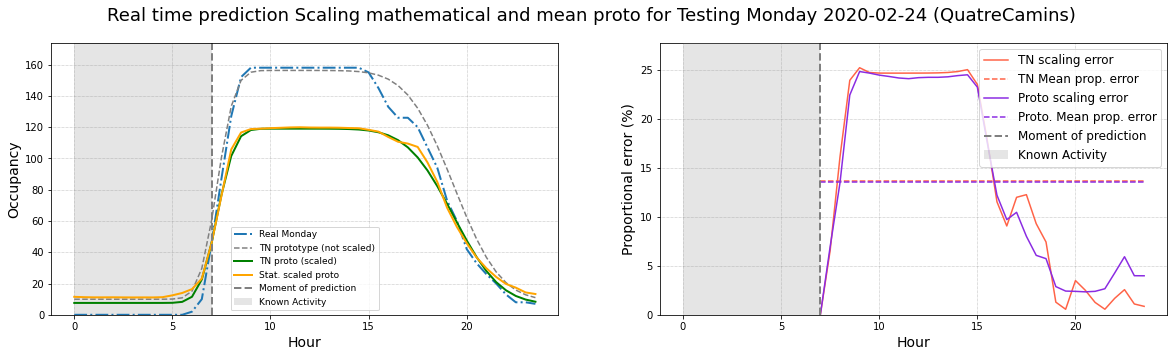

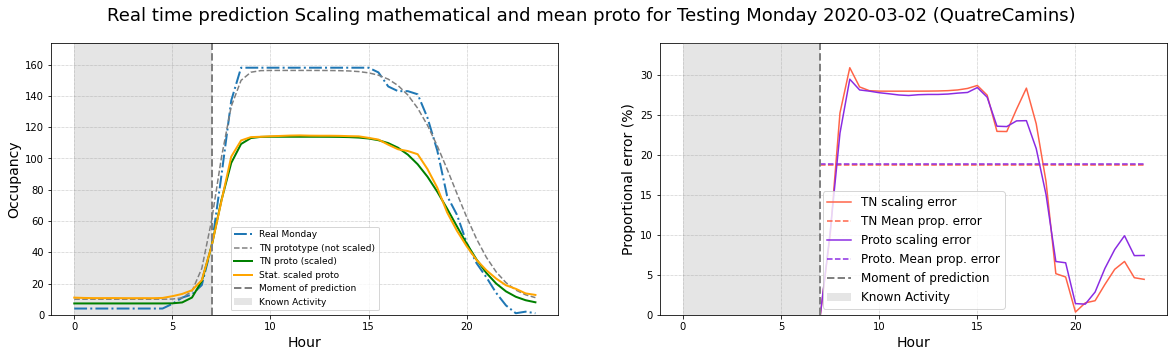

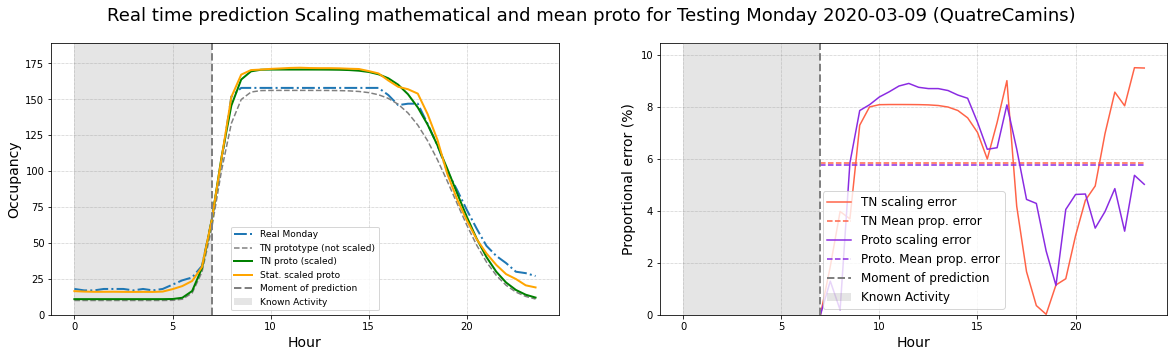

In [34]:
statistic_proto = hist_weekday_proto
tn_proto = tn_weekday
t_days = testing_mondays
t_dates=testing_mondays_dates
limit_hour = 7
day = 'Monday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(5)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

#### TUESDAY

2020-02-25
Real Tuesday scaled prtotype error:  2.96 %
Real Tuesday scaled prtotype STDV:  2.976826793856181
Real Tuesday scaled TN error:  2.92 %
Real Tuesday scaled TN STDV:  3.217988875776978
_____________________________________________________________
2020-03-03
Real Tuesday scaled prtotype error:  3.84 %
Real Tuesday scaled prtotype STDV:  3.641978792823823
Real Tuesday scaled TN error:  3.3 %
Real Tuesday scaled TN STDV:  3.3956177724100023
_____________________________________________________________
2020-03-10
Real Tuesday scaled prtotype error:  2.45 %
Real Tuesday scaled prtotype STDV:  2.1406779676353533
Real Tuesday scaled TN error:  2.92 %
Real Tuesday scaled TN STDV:  2.9868469613991833
_____________________________________________________________


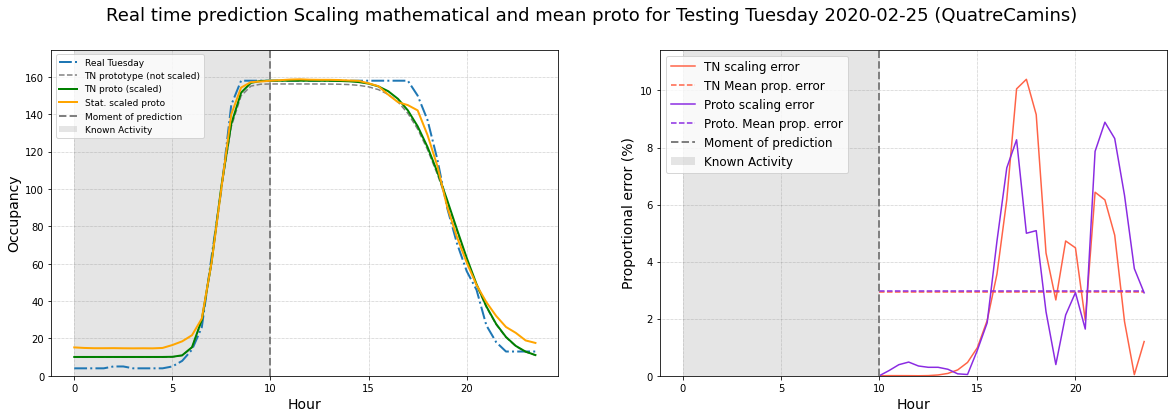

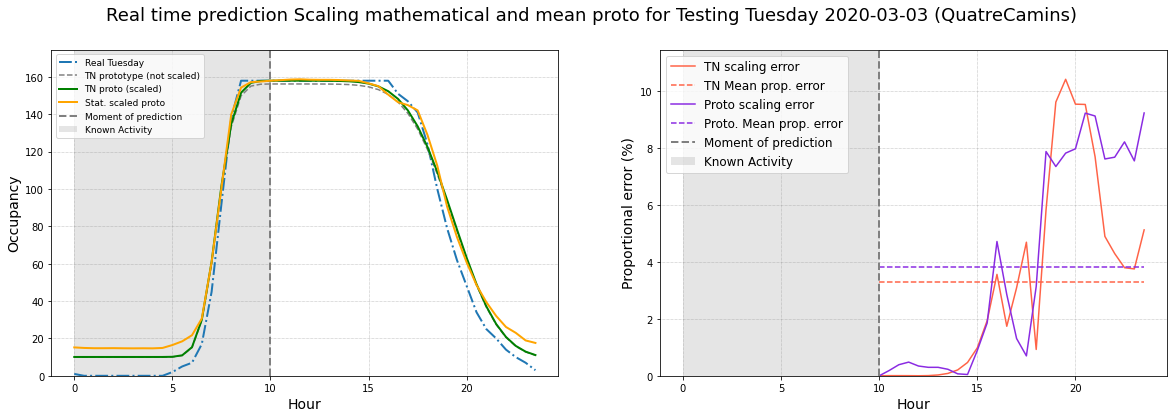

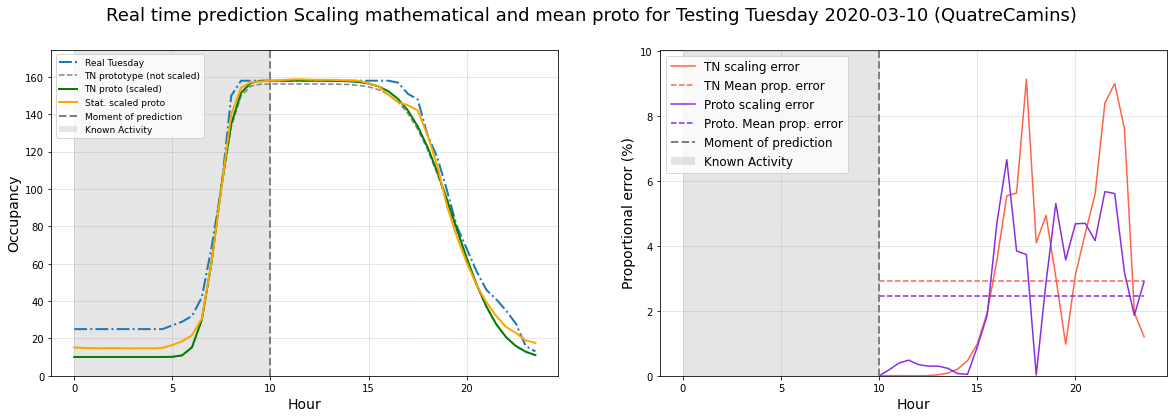

In [35]:
statistic_proto = hist_weekday_proto
tn_proto = tn_weekday
t_days = testing_tuesdays
t_dates= testing_tuesdays_dates
limit_hour = 10
day = 'Tuesday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

### WEDNESDAY

2020-02-26
Real Wednesday scaled prtotype error:  3.53 %
Real Wednesday scaled prtotype STDV:  3.493449536618509
Real Wednesday scaled TN error:  3.7 %
Real Wednesday scaled TN STDV:  4.596251959664069
_____________________________________________________________
2020-03-04
Real Wednesday scaled prtotype error:  4.58 %
Real Wednesday scaled prtotype STDV:  3.3241232963200726
Real Wednesday scaled TN error:  3.52 %
Real Wednesday scaled TN STDV:  3.1161976793599426
_____________________________________________________________
2020-03-11
Real Wednesday scaled prtotype error:  16.91 %
Real Wednesday scaled prtotype STDV:  9.23326089065558
Real Wednesday scaled TN error:  15.95 %
Real Wednesday scaled TN STDV:  9.474542977376466
_____________________________________________________________


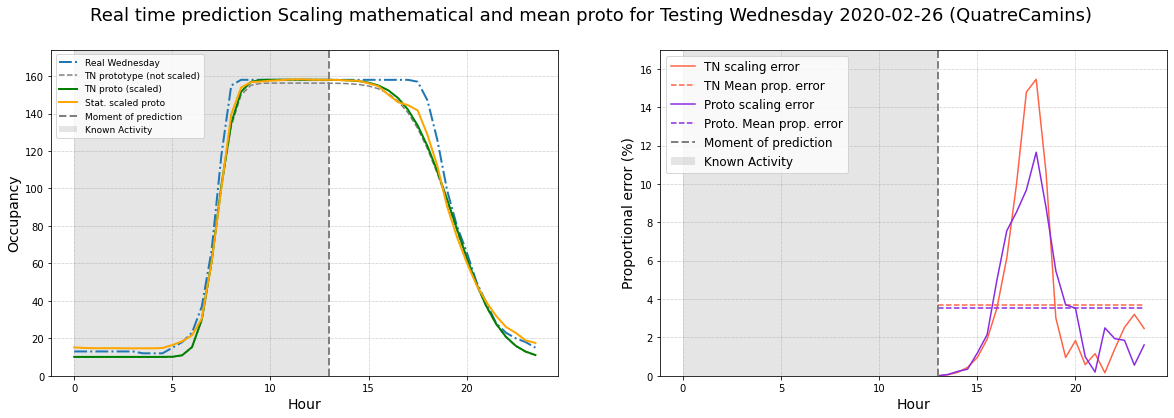

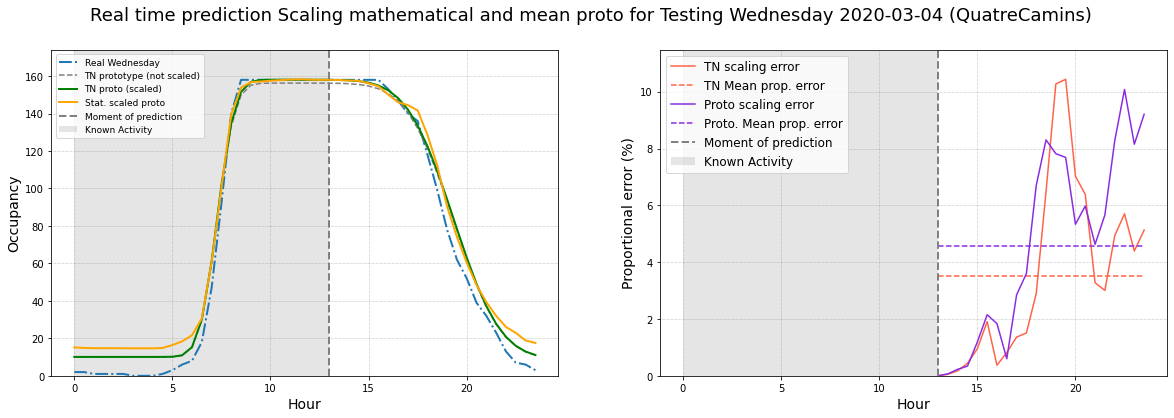

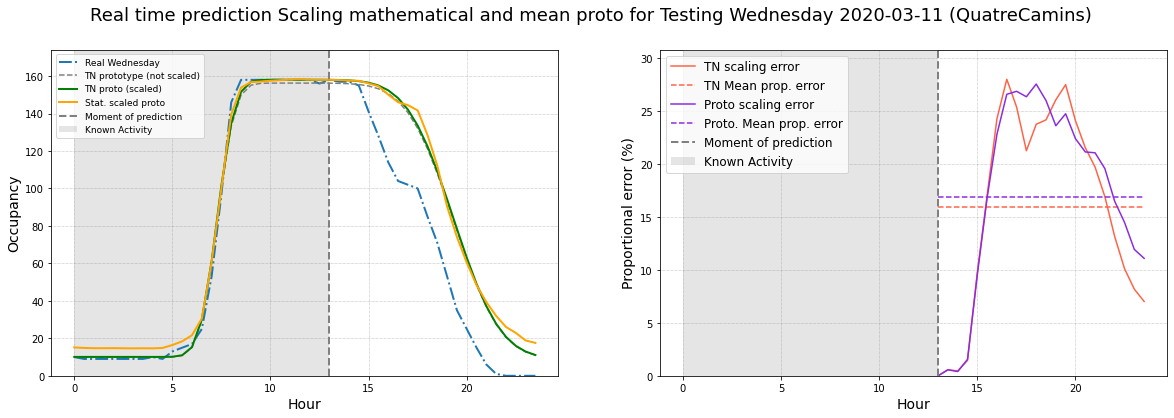

In [36]:
statistic_proto = hist_weekday_proto
tn_proto = tn_weekday
t_days = testing_wednesdays
t_dates= testing_wednesdays_dates
limit_hour = 13
day = 'Wednesday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0

cont=0        
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

### THURSDAY

2020-02-27
Real Thursday scaled prtotype error:  6.99 %
Real Thursday scaled prtotype STDV:  6.636624129560187
Real Thursday scaled TN error:  7.64 %
Real Thursday scaled TN STDV:  6.87271028972528
_____________________________________________________________
2020-03-05
Real Thursday scaled prtotype error:  2.96 %
Real Thursday scaled prtotype STDV:  2.26015141983242
Real Thursday scaled TN error:  2.53 %
Real Thursday scaled TN STDV:  2.5811738112396903
_____________________________________________________________
2020-03-12
Real Thursday scaled prtotype error:  18.87 %
Real Thursday scaled prtotype STDV:  9.648468606963545
Real Thursday scaled TN error:  17.96 %
Real Thursday scaled TN STDV:  10.09944040322922
_____________________________________________________________


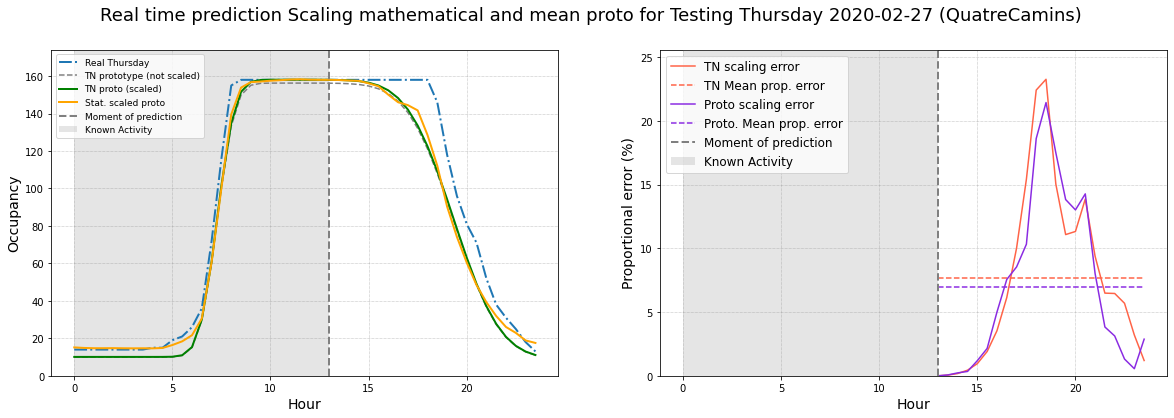

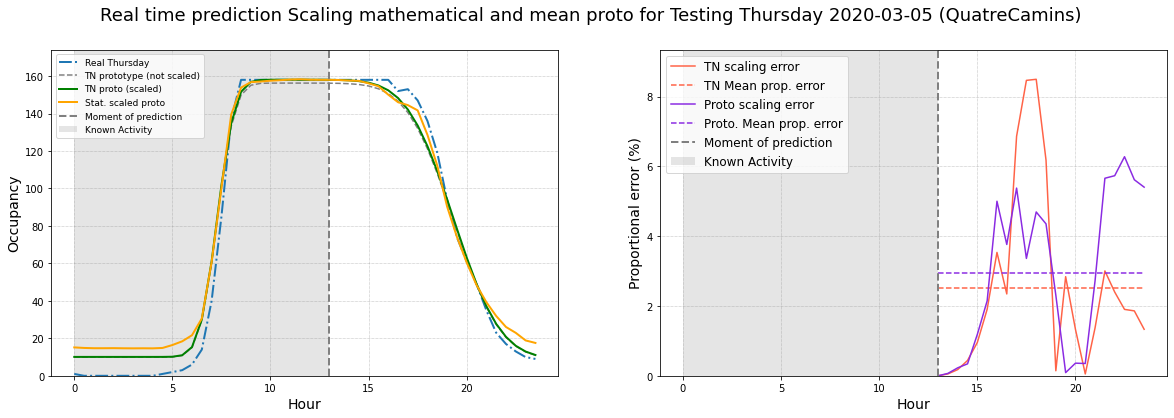

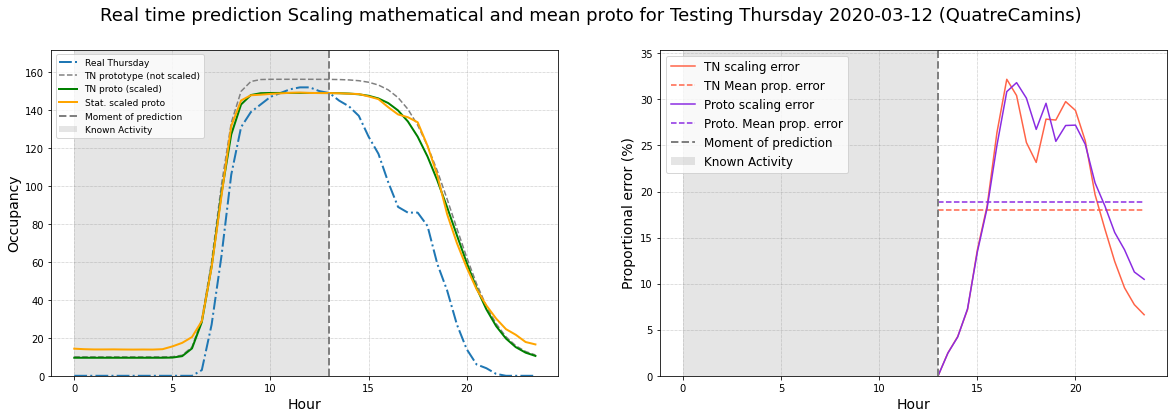

In [37]:
statistic_proto = hist_weekday_proto
tn_proto = tn_weekday
t_days = testing_thursdays
t_dates= testing_thursdays_dates
limit_hour = 13
day = 'Thursday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0
        
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1
    

### FRIDAY

2020-02-28
Real Friday scaled prtotype error:  4.35 %
Real Friday scaled prtotype STDV:  3.2930930942569523
Real Friday scaled TN error:  3.14 %
Real Friday scaled TN STDV:  1.7636036060938185
_____________________________________________________________
2020-03-06
Real Friday scaled prtotype error:  2.83 %
Real Friday scaled prtotype STDV:  1.6753713290177477
Real Friday scaled TN error:  5.38 %
Real Friday scaled TN STDV:  3.701360165937625
_____________________________________________________________
2020-03-13
Real Friday scaled prtotype error:  3.09 %
Real Friday scaled prtotype STDV:  1.5936627323056942
Real Friday scaled TN error:  2.63 %
Real Friday scaled TN STDV:  1.4924710761804612
_____________________________________________________________


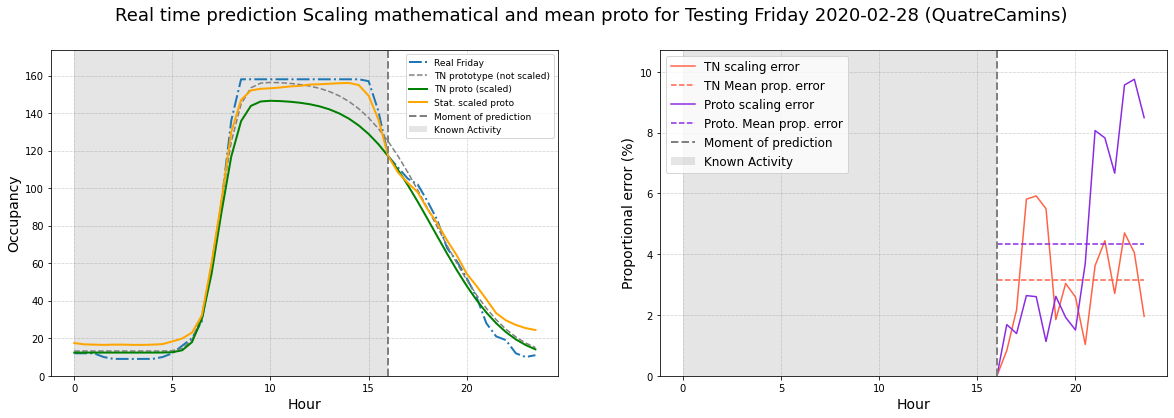

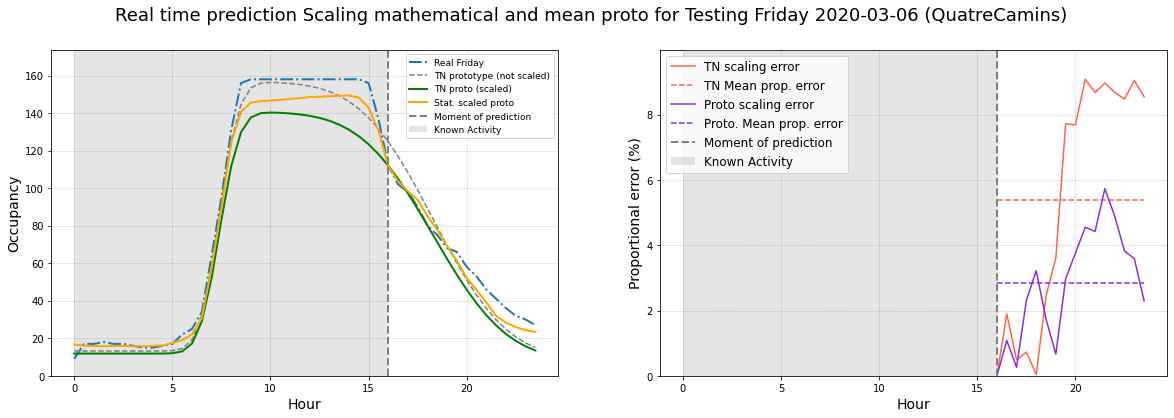

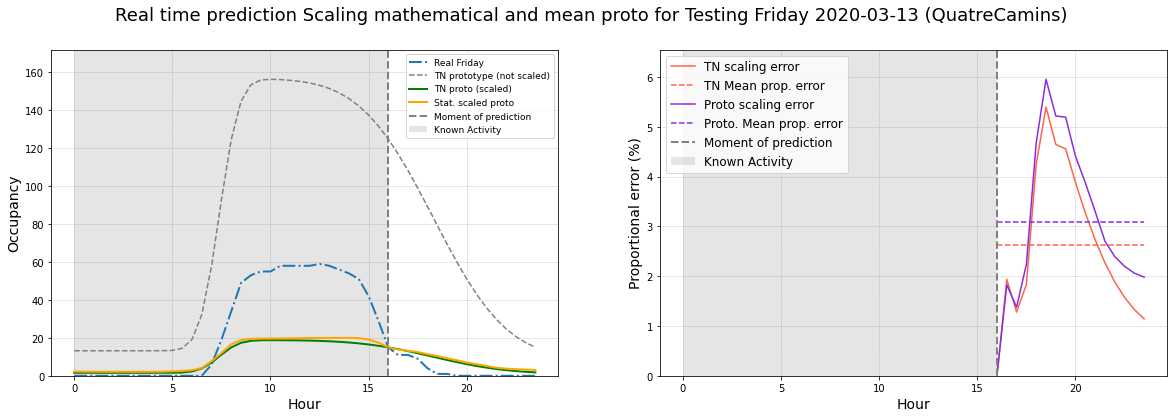

In [38]:
statistic_proto = hist_friday_proto
tn_proto = tn_friday
t_days = testing_fridays
t_dates=testing_fridays_dates
limit_hour = 16
day = 'Friday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0
  
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], statistic_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = statistic_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1
    

### WEEKEND

### SATURDAY

2020-02-22
Real Saturday scaled prtotype error:  2.99 %
Real Saturday scaled prtotype STDV:  2.403517530446649
Real Saturday scaled TN error:  2.71 %
Real Saturday scaled TN STDV:  1.8352011951234617
_____________________________________________________________
2020-02-29
Real Saturday scaled prtotype error:  2.1 %
Real Saturday scaled prtotype STDV:  2.1865202491097264
Real Saturday scaled TN error:  1.9 %
Real Saturday scaled TN STDV:  1.8684571532143828
_____________________________________________________________


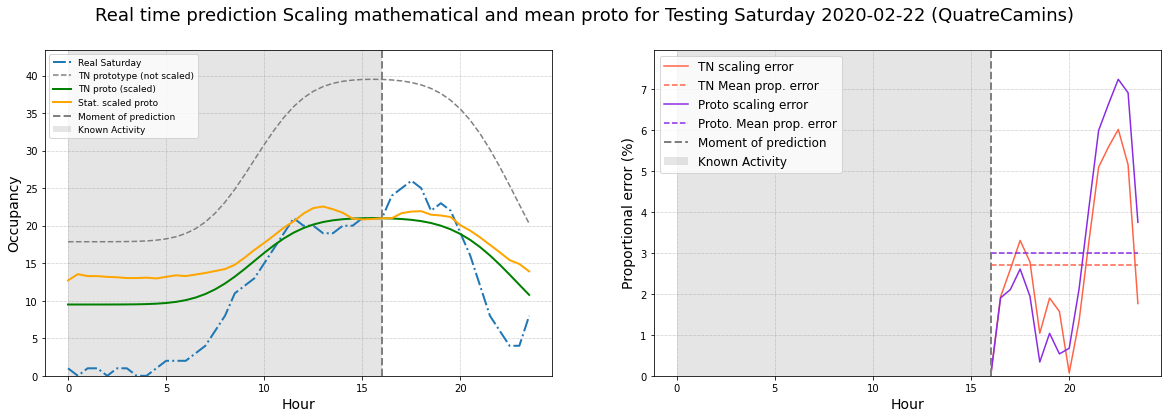

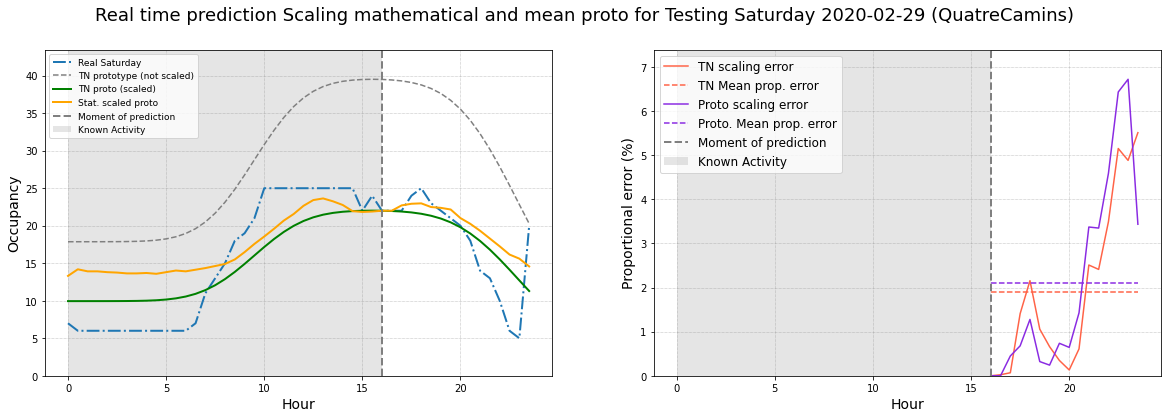

In [39]:
statistic_proto = hist_weekend_proto
tn_proto = tn1_weekend
t_days = testing_saturdays
t_dates= testing_saturdays_dates
limit_hour = 16
day = 'Saturday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0
        
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], statistic_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = statistic_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    #ax[0].set_ylim([0,axis_ylim_we])
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

### SUNDAY

2020-02-23
Real Sunday scaled prtotype error:  3.97 %
Real Sunday scaled prtotype STDV:  2.2198140752279336
Real Sunday scaled TN error:  4.24 %
Real Sunday scaled TN STDV:  2.035570232891522
_____________________________________________________________
2020-03-01
Real Sunday scaled prtotype error:  3.63 %
Real Sunday scaled prtotype STDV:  2.686988051060659
Real Sunday scaled TN error:  3.41 %
Real Sunday scaled TN STDV:  2.8643885734071324
_____________________________________________________________
2020-03-08
Real Sunday scaled prtotype error:  2.81 %
Real Sunday scaled prtotype STDV:  2.256061162461584
Real Sunday scaled TN error:  2.23 %
Real Sunday scaled TN STDV:  1.810653381064122
_____________________________________________________________


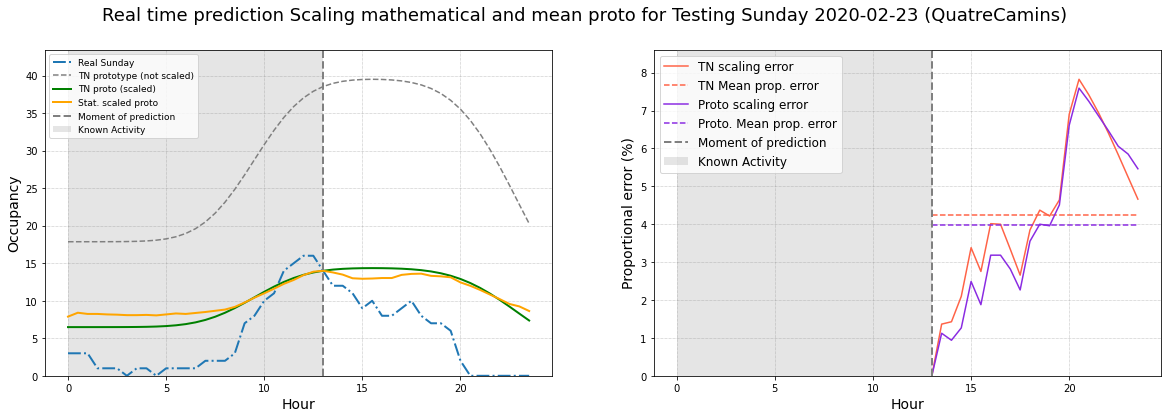

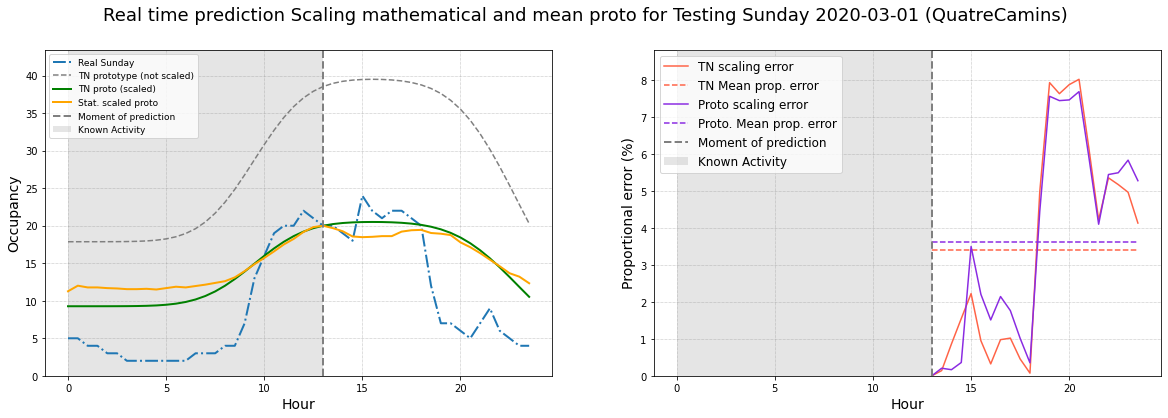

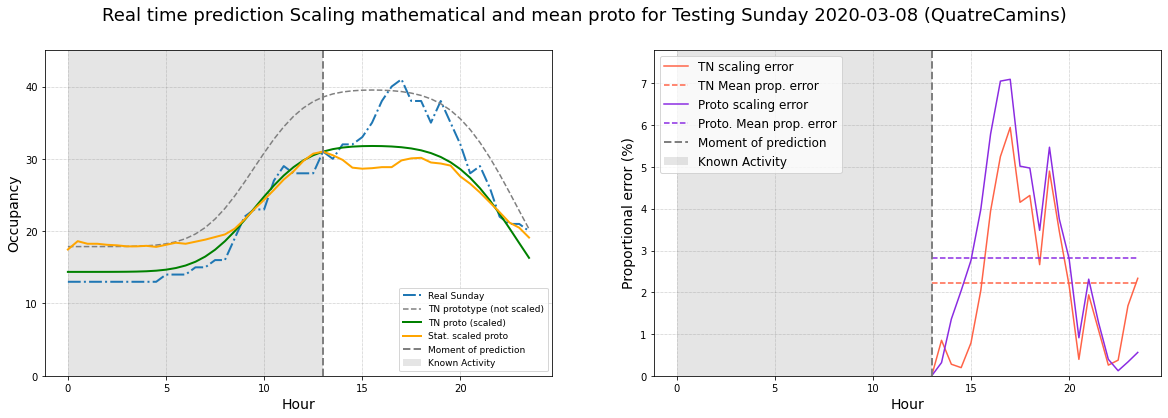

In [40]:
statistic_proto = hist_weekend_proto
tn_proto = tn1_weekend
t_days = testing_sundays
t_dates= testing_sundays_dates
limit_hour = 13
day = 'Sunday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0
    
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], statistic_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = statistic_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    #ax[0].set_ylim([0,axis_ylim_we])
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

# Store protos, params, areas and offsets

In [41]:
# df_prototypes = pd.read_csv('data/prototypes_new.csv')
# index = 0

# weekday_tn_params = ','.join(str(e) for e in list(res_weekday.x))
# friday_tn_params  = ','.join(str(e) for e in list(res_friday.x))
# weekend_tn_params = ','.join(str(e) for e in list(res_weekend.x))

# weekday_mean_area = weekday_area
# friday_mean_area  = friday_area
# weekend_mean_area = weekend_area

# weekday_mean_offset = weekday_offset
# friday_mean_offset  = friday_offset
# weekend_mean_offset = weekend_offset

# total_wave_weekday_s = ','.join(str(e) for e in tn_weekday.tolist())
# total_wave_weekend_s = ','.join(str(e) for e in tn1_weekend.tolist())
# total_wave_friday_s  = ','.join(str(e) for e in tn_friday.tolist())

# historical_weekday_s = ','.join(str(e) for e in hist_weekday_proto.tolist())
# historical_weekend_s = ','.join(str(e) for e in hist_weekend_proto.tolist())
# historical_friday_s  = ','.join(str(e) for e in hist_friday_proto.tolist())


# df_prototypes.at[index,'CDF subtraction_weekday_proto'] = total_wave_weekday_s
# df_prototypes.at[index,'CDF subtraction_friday_proto']  = total_wave_friday_s
# df_prototypes.at[index,'CDF subtraction_weekend_proto'] = total_wave_weekend_s

# df_prototypes.at[index,'CDF subtraction_weekday_params'] = weekday_tn_params
# df_prototypes.at[index,'CDF subtraction_friday_params']  = friday_tn_params
# df_prototypes.at[index,'CDF subtraction_weekend_params'] = weekend_tn_params

# df_prototypes.at[index,'CDF subtraction_weekday_area'] = weekday_mean_area
# df_prototypes.at[index,'CDF subtraction_friday_area']  = friday_mean_area
# df_prototypes.at[index,'CDF subtraction_weekend_area'] = weekend_mean_area

# df_prototypes.at[index,'CDF subtraction_weekday_offset'] = weekday_mean_offset
# df_prototypes.at[index,'CDF subtraction_friday_offset']  = friday_mean_offset
# df_prototypes.at[index,'CDF subtraction_weekend_offset'] = weekend_mean_offset

# df_prototypes.at[index,'Historical_weekday_proto'] = historical_weekday_s
# df_prototypes.at[index,'Historical_weekend_proto'] = historical_weekend_s
# df_prototypes.at[index,'Historical_friday_proto']  = historical_friday_s

# df_prototypes.to_csv("data/final_prototypes.csv", index=False)
# df_prototypes

In [42]:
# How to read the prorotypes: 
# string = exportable_df.at[0,'CDF subtraction_weekday_proto']
# list_of_strings = string.split(',')
# final_list = list(np.float_(list_of_strings))

In [43]:
# import pandas as pd
# df_prototypes_2 = pd.read_csv('data/prototypes_new.csv')
# new_row = {'Location':'Cerdanyola'}
# #append row to the dataframe
# df_prototypes_2 = df_prototypes_2.append(new_row, ignore_index=True)
# df_prototypes_2

In [44]:
# df_prototypes_2.to_csv("data/prototypes_new.csv", index=False)
# day = 'Monday'
# date = '2020-02-24'
# real_day = mean_of_day(day,date)
# real_day.values

In [45]:
# hist_friday_proto.tolist()